# Optimal Policies with Dynamic Programming
> A notebook that helps us to understand dynamic programming
- toc: true
- branch: master
- badges: true
- comments: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/pol_iter.PNG
- description: Second release in a series on understanding Reinforcement Learning.

# Section: Dynamic Programming
The term dynamic programming (DP) refers to a collection of algorithms that can be
used to compute optimal policies given a perfect model of the environment as a Markov
decision process (MDP). The key idea of DP, and of reinforcement learning generally, is the use of value functions to organize and structure the search for good policies.


In order to shed light on the Chapter 4 of the bible [Reinforcement Learning](http://www.incompleteideas.net/book/RLbook2018.pdf), the objectives of this notebook are:
- Policy Evaluation and Policy Improvement
- Value and Policy Iteration
- Bellman Equations 

# Context
We will give an example of how to apply DP into Gridworld City to deal with the City's Parking problem. The city council has created a Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences. 
- States are nonnegative integers indicating how many parking spaces are occupied.
- Actions are nonnegative integers designating the price of street parking.
- The reward is a real value describing the city's preference for the situation.
- Time is discretized by hour.

# Preliminaries
The BaseAgent, Environment and RLGlue should follow the our first Notebook on Reinforcement Learning [Exploration/Exploitation](https://dnlam.github.io/fastblog/2022/03/16/Bandits_Exploration_Exploitation.html). 

The construction of a virtual ParkingWorld and the plot function are given below:

In [15]:
#hide_input
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
import time
import json
from copy import deepcopy

plt.rc('font', size=30)  # controls default text sizes
plt.rc('axes', titlesize=25)  # fontsize of the axes title
plt.rc('axes', labelsize=25)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=17)  # fontsize of the tick labels
plt.rc('ytick', labelsize=17)  # fontsize of the tick labels
plt.rc('legend', fontsize=20)  # legend fontsize
plt.rc('figure', titlesize=30)
plt.tight_layout()

class ParkingWorld:
    def __init__(self,
                 num_spaces=10,
                 num_prices=4,
                 price_factor=0.1,
                 occupants_factor=1.0,
                 null_factor=1 / 3):
        self.__num_spaces = num_spaces
        self.__num_prices = num_prices
        self.__occupants_factor = occupants_factor
        self.__price_factor = price_factor
        self.__null_factor = null_factor
        self.__S = [num_occupied for num_occupied in range(num_spaces + 1)]
        self.__A = list(range(num_prices))


    def transitions(self, s, a):
        return np.array([[r, self.p(s_, r, s, a)] for s_, r in self.support(s, a)])

    def support(self, s, a):
        return [(s_, self.reward(s, s_)) for s_ in self.__S]

    def p(self, s_, r, s, a):
        if r != self.reward(s, s_):
            return 0
        else:
            center = (1 - self.__price_factor
                      ) * s + self.__price_factor * self.__num_spaces * (
                          1 - a / self.__num_prices)
            emphasis = np.exp(
                -abs(np.arange(2 * self.__num_spaces) - center) / 5)
            if s_ == self.__num_spaces:
                return sum(emphasis[s_:]) / sum(emphasis)
            return emphasis[s_] / sum(emphasis)

    def reward(self, s, s_):
        return self.state_reward(s) + self.state_reward(s_)

    def state_reward(self, s):
        if s == self.__num_spaces:
            return self.__null_factor * s * self.__occupants_factor
        else:
            return s * self.__occupants_factor

    def random_state(self):
        return np.random.randint(self.__num_prices)

    def step(self, s, a):
        probabilities = [
            self.p(s_, self.reward(s, s_), s, a) for s_ in self.__S
        ]
        return np.random.choice(self.__S, p=probabilities)

    @property
    def A(self):
        return list(self.__A)

    @property
    def num_spaces(self):
        return self.__num_spaces

    @property
    def num_prices(self):
        return self.num_prices

    @property
    def S(self):
        return list(self.__S)


class Transitions(list):
    def __init__(self, transitions):
        self.__transitions = transitions
        super().__init__(transitions)

    def __repr__(self):
        repr = '{:<14} {:<10} {:<10}'.format('Next State', 'Reward',
                                             'Probability')
        repr += '\n'
        for i, (s, r, p) in enumerate(self.__transitions):
            repr += '{:<14} {:<10} {:<10}'.format(s, round(r, 2), round(p, 2))
            if i != len(self.__transitions) - 1:
                repr += '\n'
        return repr
        
def plot(V, pi):
    # plot value
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))
    ax1.axis('on')
    ax1.cla()
    states = np.arange(V.shape[0])
    ax1.bar(states, V, edgecolor='none')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value', rotation='horizontal', ha='right')
    ax1.set_title('Value Function')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax1.yaxis.grid()
    ax1.set_ylim(bottom=V.min())
    # plot policy
    ax2.axis('on')
    ax2.cla()
    im = ax2.imshow(pi.T, cmap='Greys', vmin=0, vmax=1, aspect='auto')
    ax2.invert_yaxis()
    ax2.set_xlabel('State')
    ax2.set_ylabel('Action', rotation='horizontal', ha='right')
    ax2.set_title('Policy')
    start, end = ax2.get_xlim()
    ax2.xaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    start, end = ax2.get_ylim()
    ax2.yaxis.set_ticks(np.arange(start, end), minor=True)
    ax2.grid(which='minor')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.20)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label('Probability', rotation=0, ha='left')
    fig.subplots_adjust(wspace=0.5)
    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.001)
    plt.close()



<Figure size 432x288 with 0 Axes>

In [16]:
#hide_input
def near(arr1, arr2, thresh):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    return np.all(np.abs(arr1 - arr2) < thresh)

# Section 1: Policy Evaluation

First, the city council would like you to evaluate the quality of the existing pricing scheme. Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. **In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the [textbook](https://dnlam.github.io/fastblog/2022/03/16/Bandits_Exploration_Exploitation.html). 


The policy evaluation can be expressed in the code below:

In [17]:
def evaluate_policy(env, V, pi, gamma, theta):
    delta = float('inf')
    while delta > theta:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
    return V

Then, the Bellman update will be:

In [18]:
def bellman_update(env, V, pi, s, gamma):
    """Mutate ``V`` according to the Bellman update equation."""
    v = 0
    for a in env.A:
        transitions = env.transitions(s, a)
        for s_, (r, p) in enumerate(transitions):
            v += pi[s][a] * p * (r + gamma * V[s_])
    V[s] = v

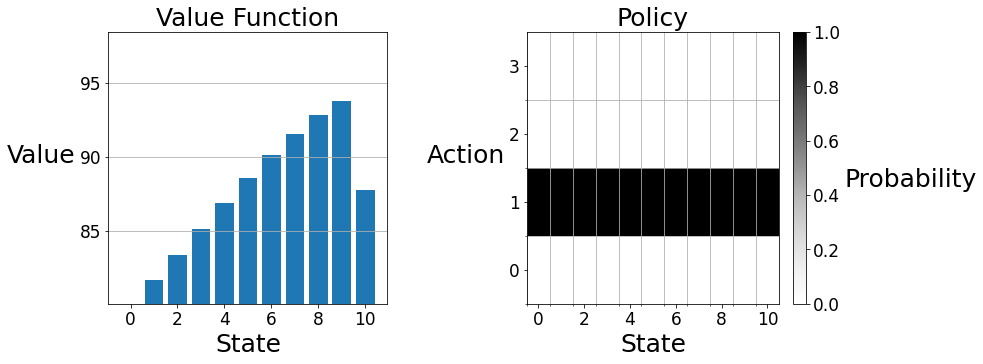

In [20]:
#hide_input
# set up test environment
num_spaces = 10
num_prices = 4
env = ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

# test the value function
answer = [80.04, 81.65, 83.37, 85.12, 86.87, 88.55, 90.14, 91.58, 92.81, 93.78, 87.77]

print(V)
print(city_policy)
plot(V, city_policy)

The observation shows that the value monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. Because of the relatively simple reward function (more reward is accrued when many but not all parking spots are taken and less reward is accrued when few or all parking spots are taken) and the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. However, depending on the intelligence of the policy, the scale of the graph will differ. In other words, better policies will increase the expected return at every state rather than changing the relative desirability of the states. Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. That is to say, good policies are policies that spend more time in desirable states and less time in undesirable states. As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

# Policy Iteration
Now the city council would like to propose a more efficient policy using policy iteration. Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function. 

In [21]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        
        if not np.array_equal(pi[s], old):
            policy_stable = False
            
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
        
    return V, pi

In [22]:
def q_greedify_policy(env, V, pi, s, gamma):
    """Mutate ``pi`` to be greedy with respect to the q-values induced by ``V``."""
    G = np.zeros_like(env.A, dtype=float)
    for a in env.A:
        transitions = env.transitions(s, a)
        for s_, (r, p) in enumerate(transitions):
            G[a] += p * (r + gamma * V[s_])
            
    greed_actions = np.argwhere(G == np.amax(G))
    for a in env.A:
        if a in greed_actions:
            pi[s, a] = 1 / len(greed_actions)
        else:
            pi[s, a] = 0

In [23]:
#hide_input
gamma = 0.9
theta = 0.1
env = ParkingWorld(num_spaces=10, num_prices=4)

V, pi = policy_iteration(env, gamma, theta)

V_answer = [81.60, 83.28, 85.03, 86.79, 88.51, 90.16, 91.70, 93.08, 94.25, 95.25, 89.45]
pi_answer = [
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

In [24]:
#hide_input
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)
plot(V, pi)

# Section 3: Value Iteration
Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$

In [26]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [27]:
def bellman_optimality_update(env, V, s, gamma):
    """Mutate ``V`` according to the Bellman optimality update equation."""
    vmax = - float('inf')
    for a in env.A:
        transitions = env.transitions(s, a)
        va = 0
        for s_, (r, p) in enumerate(transitions):
            va += p * (r + gamma * V[s_])
        vmax = max(va, vmax)
    V[s] = vmax

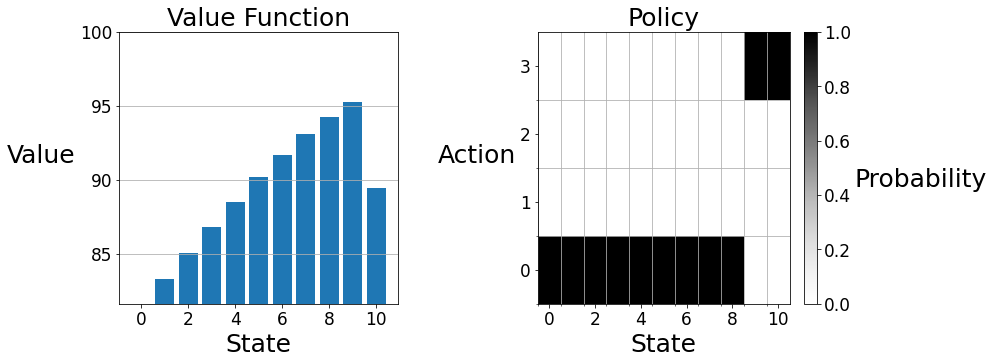

In [28]:
#hide_input
gamma = 0.9
env = ParkingWorld(num_spaces=10, num_prices=4)

V = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

for _ in range(10):
    for s in env.S:
        bellman_optimality_update(env, V, s, gamma)

# make sure value function is exactly correct
answer = [61, 63, 65, 67, 69, 71, 72, 74, 75, 76, 71]
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)
plot(V, pi)

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. Writing value iteration in this form makes its relationship to policy iteration more evident. Policy iteration alternates between doing complete greedifications and complete evaluations. On the other hand, value iteration alternates between doing local greedifications and local evaluations. 

In [29]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

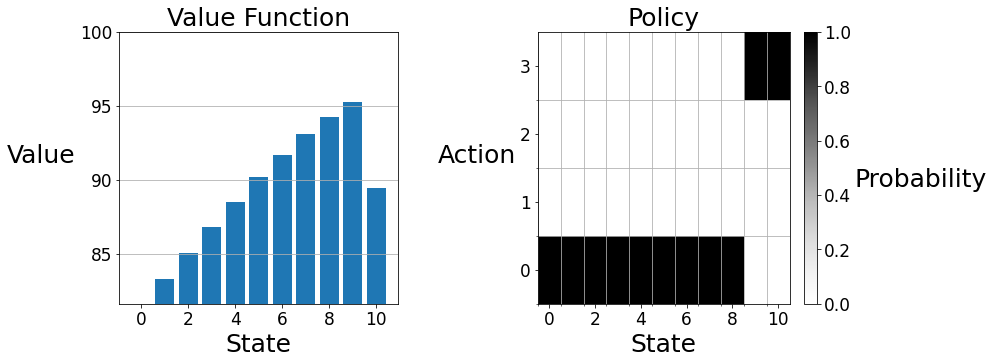

In [30]:
#hide_input
env = ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
plot(V, pi)